# V. Accessing SEN-2 and SEN-1 for MOSAIC NLHI Project
---
**Author:** Pierre Sosnowski

---

## 1. Summary

### Satellite data needed
* Sentinel-2 data Level-2A with less than 1% cloud cover, pre-processed using Sen2Cor over periods 01/01/2016-31/12/2017 and 01/01/2020-31/12/2021
* Sentinel-1 data (VV and VH) preprocessed using S1TBX over periods 01/01/2016-31/12/2017 and 01/01/2020-31/12/2021
### Vector data needed
* Polygons of study sites

In [1]:
# STAC access
import teledetection as tld
import pystac_client

# dataframes
import pandas as pd

# xarrays
import xarray as xry

# library for turning STAC objects into xarrays
import stackstac

# visualization
from matplotlib import pyplot as plt

# miscellanous
import numpy as np
from IPython.display import display
from datetime import date

import matplotlib.dates as mdates

## 2. Which collections exist?

In [2]:
import pystac_client

# Open the API as before
api = pystac_client.Client.open(
    "https://stacapi-cdos.apps.okd.crocc.meso.umontpellier.fr",
    modifier=tld.sign_inplace,
)

# Get all collections
collections = api.get_collections()

# Print collection IDs
for collection in collections:
    print(collection.id)


sentinel2-l2a-sen2lasrc
corona-4b
becarun
s1-grd-sigma0-ortho
spot-6-7-trees-footprint
spot-6-7-footprints
costarica-sentinel-2-l2-spectral-indices
costarica-sentinel-2-l3-seasonal-spectral-indices
costarica-sentinel-2-l3-seasonal-spectral-indices-M
costarica-sentinel-2-l4-seasonal-diversity-indices
spot-6-7-drs
geogedi
super-sentinel-2-l2a
oso
spot-6-7-buildings-footprint
sentinel-derived-soil-moisture-oldprod
spot-6-7-solar-panels
french-tiled-rpg
forms-t
spot-6-7-solar-panels-v2
srtm-gl1-hgt
reconfort-chene
sentinel2-l2a-theia-patches-stats
sentinel2-l2a-sen2cor
lidarhd
s1-grd-sigma0-ortho-patches-stats
fordead-fit
s2mp-rpg-fr
sentinel2-l2a-theia
fordead-predict
sentinel-2-radiometric-indices


## 3. Accessing SEN-2

### 3.1. Request on a STAC catalog

Identify the STAC Collection we're interested in (see [this notebook](01-STAC.ipynb) for a refresher), and load the area of interest defined as a bounding box.

In [5]:
# Import area of interest
import geopandas as gpd
from shapely.geometry import box

# Define the path to your shapefile
shapefile_path = r"C:\Users\pedro\Dropbox\Database\MOSAIC\GIS\StudyAreas_Brazil_5880.shp"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Display the first few rows
print(gdf.head())

# Reproject to EPSG:4326 if necessary
gdf_wgs84 = gdf.to_crs("EPSG:4326")
bboxgdf = list(gdf_wgs84.total_bounds)

# Get the geometry of the polygon i
first_geom = gdf_wgs84.geometry.iloc[0]

# Get its bounding box as (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = first_geom.bounds

# Optionally, convert it to a list (useful for bbox parameters)
bbox_polyi = [minx, miny, maxx, maxy]

# Print the bounding box
print(f"Bounding box of ith polygon: {bbox_polyi}")


   Name descriptio timestamp begin   end altitudeMo  tessellate  extrude  \
0  None       None      None  None  None       None        -1.0      0.0   
1  None       None      None  None  None       None        -1.0      0.0   
2  None       None      None  None  None       None        -1.0      0.0   
3  None       None      None  None  None       None        -1.0      0.0   
4  None       None      None  None  None       None        -1.0      0.0   

   visibility  drawOrder  icon   id          Area  \
0        -1.0        NaN  None  1.0  7.596702e+06   
1        -1.0        NaN  None  2.0  5.155483e+06   
2        -1.0        NaN  None  3.0  2.981143e+06   
3        -1.0        NaN  None  4.0  2.086643e+06   
4        -1.0        NaN  None  5.0  3.798350e+05   

                                            geometry  
0  POLYGON ((2889753.294 8987527.48, 2880464.245 ...  
1  POLYGON ((5184980.477 9515565.01, 5185315.271 ...  
2  POLYGON ((5176825.648 10334985.24, 5176503.459...  
3  P

## Display polygons of interest

In [40]:
# Project polygons on google earth sat map
import folium

# Load shapefile
shapefile_path = r"C:\Users\pedro\Dropbox\Database\MOSAIC\GIS\StudyAreas_Brazil_5880.shp"
gdf = gpd.read_file(shapefile_path)

# Reproject to WGS84 (lat/lon)
gdf_wgs84 = gdf.to_crs(epsg=4326)

# Create a Folium map (initial location doesn’t matter if we fit bounds)
m = folium.Map(tiles="OpenStreetMap")

# Add polygons
for _, row in gdf_wgs84.iterrows():
    # Polygon geometry as GeoJSON
    sim_geo = gpd.GeoSeries([row["geometry"]]).to_json()
    
    # Add polygon
    folium.GeoJson(
        sim_geo,
        style_function=lambda x: {"fillColor": "none", "color": "red", "weight": 2}
    ).add_to(m)
    
    # Compute centroid for label
    centroid = row["geometry"].centroid
    folium.map.Marker(
        [centroid.y, centroid.x],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12pt; color: red; font-weight:bold">{row['id']}</div>"""
        )
    ).add_to(m)

# Add Google Satellite basemap
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=False,
    control=True
).add_to(m)

# Fit map to polygon bounds
m.fit_bounds([[gdf_wgs84.total_bounds[1], gdf_wgs84.total_bounds[0]],
              [gdf_wgs84.total_bounds[3], gdf_wgs84.total_bounds[2]]])

folium.LayerControl().add_to(m)

m


In [6]:

# retrieving the relevant STAC Item
api = pystac_client.Client.open(
    "https://stacapi-cdos.apps.okd.crocc.meso.umontpellier.fr",
    modifier=tld.sign_inplace,
)

today = date.today()
last_year = today.replace(year=today.year - 1).strftime("%Y-%m")
time_range = f"2016-01-01/2021-12-31"
search = api.search(
    collections=["sentinel2-l2a-sen2cor"], datetime=time_range, bbox=bbox_polyi
)
items = search.item_collection()
print(f"{len(items)} items found")

1479 items found


### 3.2. Explore the items

In [14]:
items[0]

<Item id=S2A_20211226T151711024Z_18LXR_0500_42dae0fc60>

#### Filter the items based on cloud cover

In [7]:
item = items[0]
cloud_cover = item.properties.get("eo:cloud_cover")
print(cloud_cover)


9.02


In [8]:
filtered_items = [item for item in items 
                  if item.properties.get("eo:cloud_cover", 100) <= 100]
for item in filtered_items[1:10]:
    print(item.id, item.properties["eo:cloud_cover"])

S2A_20211226T151711024Z_18LXR_0500_364cb946de 6.67
S2B_20211225T145719024Z_18MZS_0500_71e1872b2f 33.6
S2A_20211213T150721024Z_19MCN_0500_b229316775 13.37
S2B_20211208T150719024Z_19MBN_0500_5eeb6a5393 30.03
S2A_20211203T150721024Z_19MBM_0500_4d1589a47f 33.11
S2A_20211203T150721024Z_19LBL_0500_7e776b8022 32.04
S2A_20211203T150721024Z_18MZS_0500_a78055a1c9 31.97
S2B_20211128T150719024Z_19MCN_0500_66a043d296 24.7
S2A_20211127T144731024Z_19LDL_0500_ec9b60ef6b 26.71


#### Print asset description of first item

In [31]:
item = items[0]
assets = [asset.title for asset in item.assets.values()]
descriptions = pd.DataFrame(
    assets,
    columns=["Description"],
    index=pd.Series(item.assets.keys(), name="asset_key"),
)
descriptions

Description
asset_key                                                
QL                                              Quicklook
AOT                       Aerosol optical thickness (AOT)
B01                        Band 1 - Coastal aerosol - 60m
B02                                   Band 2 - Blue - 10m
B03                                  Band 3 - Green - 10m
B04                                    Band 4 - Red - 10m
B05                  Band 5 - Vegetation red edge 1 - 20m
B06                  Band 6 - Vegetation red edge 2 - 20m
B07                  Band 7 - Vegetation red edge 3 - 20m
B08                                    Band 8 - NIR - 10m
B09                            Band 9 - Water vapor - 60m
B11                            Band 11 - SWIR (1.6) - 20m
B12                            Band 12 - SWIR (2.2) - 20m
B8A                 Band 8A - Vegetation red edge 4 - 20m
SCL                         Scene classfication map (SCL)
WVP                                    Water vapour (WVP)
safe-manifest                               SAFE manifest
granule-metadata                         Granule metadata
inspire-metadata                         INSPIRE metadata
product-metadata                         Product metadata
datastrip-metadata                     Datastrip metadata

In [32]:
filtered_items[0]

<Item id=S2A_20211226T151711024Z_18LXR_0500_42dae0fc60>

In [33]:
len(filtered_items)

1479

### Display filtered images

In [7]:
import folium

for item in filtered_items:
    # GeoJSON polygon coordinates
    coords = item.geometry['coordinates'][0]  # list of [lon, lat] pairs
    
    # Convert to folium order [lat, lon]
    polygon = [[lat, lon] for lon, lat in coords]
    
    folium.Polygon(
        locations=polygon,
        color='blue',
        weight=1,
        fill=False,
        fill_opacity=0.3,
        popup=item.properties.get('s2:mgrs_tile', 'Tile')
    ).add_to(m)


In [8]:
from IPython.display import display
display(m)

In [ ]:
m.save("map.html")

#### Convert filtered list to data array

> <span style='color:red'> **IMPORTANT:** The URLs that we obtain from the STAC Catalog are not valid indefinitely. They expire after about 30 minutes. If you see an error in the notebook, it is likely because the URL that you obtained by running the first few cells has now expired.</span> If that happens you should be able to just run the notebook again from the top to get a new URL. You can get longer-lasting URLs by signing up for Planetary Computer (which is free at the time of writing this notebook). More info [here](https://planetarycomputer.microsoft.com/docs/concepts/sas/). 

In [9]:
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12"]
FILL_VALUE = 2**16 - 1
array = stackstac.stack(
    filtered_items,
    assets=bands,
    resolution=10,
    fill_value=FILL_VALUE,
    bounds_latlon=bbox_polyi,
    epsg = 4326,
)
array

<xarray.DataArray 'stackstac-dd96bfbe7522bd7de241815b38a4b366' (time: 1328,
                                                                band: 9, y: 1,
                                                                x: 2)> Size: 191kB
dask.array<fetch_raster_window, shape=(1328, 9, 1, 2), dtype=float64, chunksize=(1, 1, 1, 2), chunktype=numpy.ndarray>
Coordinates: (12/32)
  * time                                   (time) datetime64[ns] 11kB 2016-01...
    id                                     (time) <U45 239kB 'S2A_20160108T14...
  * band                                   (band) <U3 108B 'B02' 'B03' ... 'B12'
  * x                                      (x) float64 16B -80.0 -70.0
  * y                                      (y) float64 8B 0.0
    sat:absolute_orbit                     (time) int32 5kB 2853 2939 ... 34013
    ...                                     ...
    processing:facility                    <U3 12B 'ESA'
    s2:vegetation_percentage               (time) float64 11kB 78.84 ... 86.93
    title                                  (band) <U36 1kB 'Band 2 - Blue - 1...
    production:implementation_sha          <U40 160B '782f86cad0698fdbacaf151...
    production:definition_sha              <U40 160B 'ea7f6376c124e09d036dc8a...
    epsg                                   int32 4B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-80, -10, -60, 0), resolutions...
    crs:         epsg:4326
    transform:   | 10.00, 0.00,-80.00|\n| 0.00,-10.00, 0.00|\n| 0.00, 0.00, 1...
    resolution:  10

C:\Users\pedro\AppData\Local\Temp\ipykernel_11124\1961327713.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


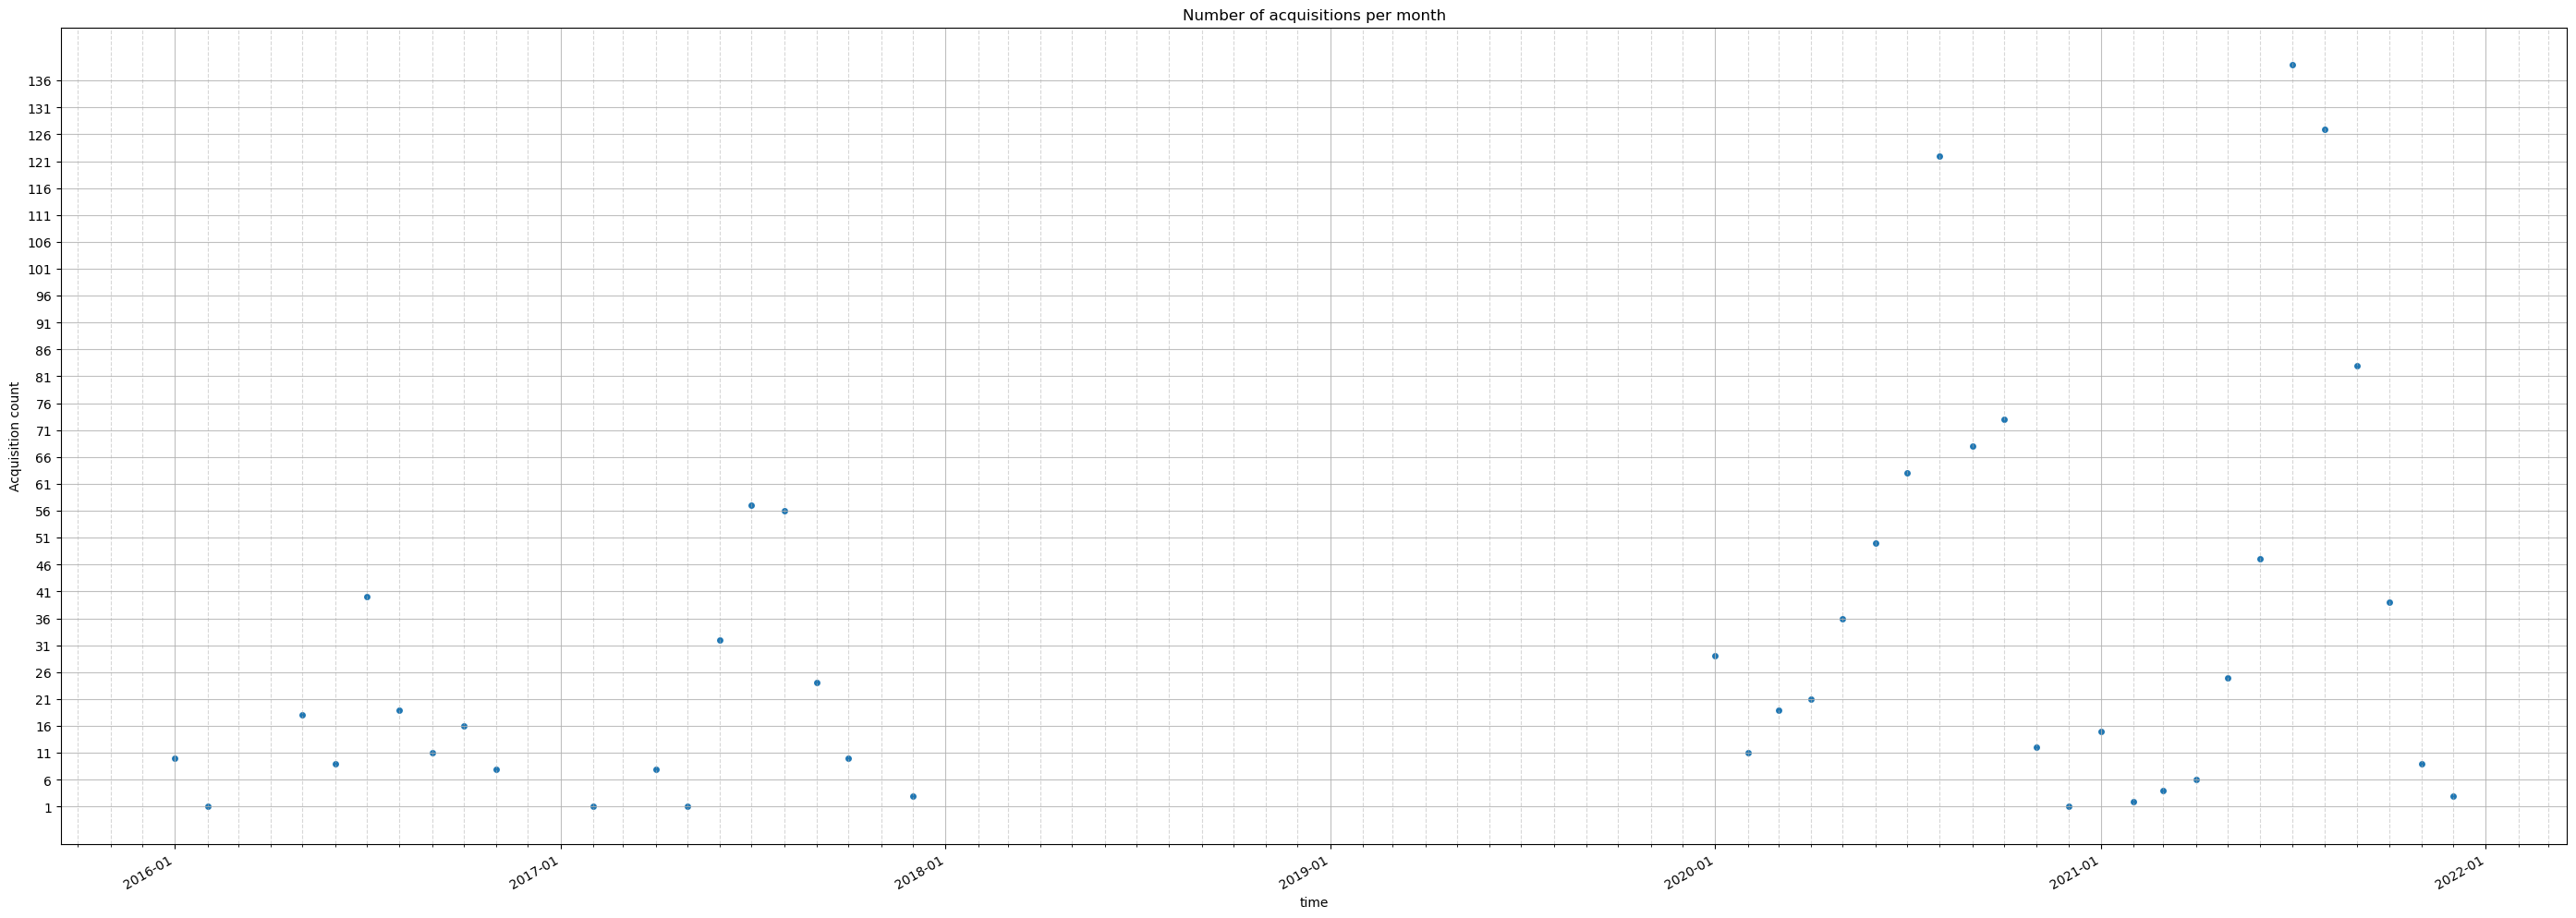

In [12]:
 # counting the number of acquisitons per month
import matplotlib.dates as mdates

# resampling and counting for each month
# using MS (Month Start) as we prefer using the first day
# of the month as a reference point instead of the last
# acquisition date of the month
ar = array.time.sortby("time").resample(time="MS").count()


fig, ax = plt.subplots(figsize=(35, 13))
ar.plot.scatter(ax=ax, x="time")
ax.set_ylabel("Acquisition count")
ax.set_title("Number of acquisitions per month")

# setting y ticks manually to avoid non-integer values being used
ymin = int(ar.min().values)
ymax = int(ar.max().values)

ax.set_yticks(range(ymin, ymax + 1,5))

# Format x-axis to show year-month
ax.xaxis.set_minor_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  

fig.autofmt_xdate()  # rotate labels so they don't overlap

# Grid on minor ticks (months)
ax.grid(which="minor", linestyle="--", alpha=0.5)
ax.grid(which="major", linestyle="-", alpha=0.8)

fig.show()

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert coordinates to a DataFrame
df = array.coords.to_dataset()[["s2:mgrs_tile"]].to_dataframe()

# Add month column (month start)
df['month'] = df.index.to_period('M').to_timestamp()

# Count number of acquisitions per tile per month
counts = df.groupby(['month', 's2:mgrs_tile']).size().unstack(fill_value=0)

counts

s2:mgrs_tile  18LXR  18LYR  18LZR  18MXS  18MXT  18MYS  18MYT  18MZS  18MZT  \
month                                                                         
2016-01-01        0      0      1      0      1      1      1      1      1   
2016-02-01        0      0      0      1      0      0      0      0      0   
2016-05-01        2      1      2      1      1      1      1      1      1   
2016-06-01        2      0      1      2      0      0      0      0      0   
2016-07-01        4      2      4      2      2      1      1      2      1   
2016-08-01        2      0      1      2      1      0      0      1      0   
2016-09-01        1      0      1      1      1      0      0      0      0   
2016-10-01        1      1      1      1      1      1      1      1      1   
2016-11-01        1      0      0      1      1      0      0      0      0   
2017-02-01        1      0      0      0      0      0      0      0      0   
2017-04-01        1      0      0      1      1      1      1      1      1   
2017-05-01        0      0      0      0      0      0      0      0      0   
2017-06-01        2      1      1      2      1      1      0      1      0   
2017-07-01        5      2      4      4      4      2      1      3      1   
2017-08-01        4      1      5      2      1      2      1      5      1   
2017-09-01        1      1      3      0      0      0      0      2      0   
2017-10-01        1      1      0      2      2      1      0      1      0   
2017-12-01        0      0      0      0      1      0      0      0      0   
2020-01-01        3      0      1      4      4      1      2      1      2   
2020-02-01        2      0      1      2      1      0      0      0      0   
2020-03-01        2      1      1      2      1      2      1      0      1   
2020-04-01        2      1      1      2      3      1      1      1      0   
2020-05-01        2      3      5      2      1      3      0      4      0   
2020-06-01        4      2      4      3      2      1      1      3      1   
2020-07-01        3      2      6      4      3      3      2      4      2   
2020-08-01        7      3     10     10      8      3      3      9      4   
2020-09-01        5      3      7      8      5      3      1      5      1   
2020-10-01        5      2      6      4      5      2      0      8      2   
2020-11-01        1      1      1      1      2      1      1      1      0   
2020-12-01        0      0      0      0      0      0      0      0      0   
2021-01-01        2      0      1      2      0      0      1      2      0   
2021-02-01        0      0      0      0      1      0      0      1      0   
2021-03-01        0      0      0      1      0      0      0      1      0   
2021-04-01        1      0      1      2      0      0      0      0      0   
2021-05-01        2      0      3      2      2      1      0      1      0   
2021-06-01        4      4      6      3      2      2      1      3      1   
2021-07-01        9      6     12      9      9      8      6     11      6   
2021-08-01        7      4      9      8      9      4      4      7      4   
2021-09-01        6      4      5      5      4      4      5      7      6   
2021-10-01        2      1      2      1      2      2      3      2      3   
2021-11-01        3      0      0      0      0      0      0      0      0   
2021-12-01        2      0      0      0      0      0      0      0      0   

s2:mgrs_tile  19LBL  19LCL  19LDL  19MBM  19MBN  19MCM  19MCN  19MDM  19MDN  
month                                                                        
2016-01-01        1      0      1      0      1      0      1      0      0  
2016-02-01        0      0      0      0      0      0      0      0      0  
2016-05-01        2      1      1      1      1      0      1      0      0  
2016-06-01        1      1      2      0      0      0      0      0      0  
2016-07-01        4      2      3      2      3      1 

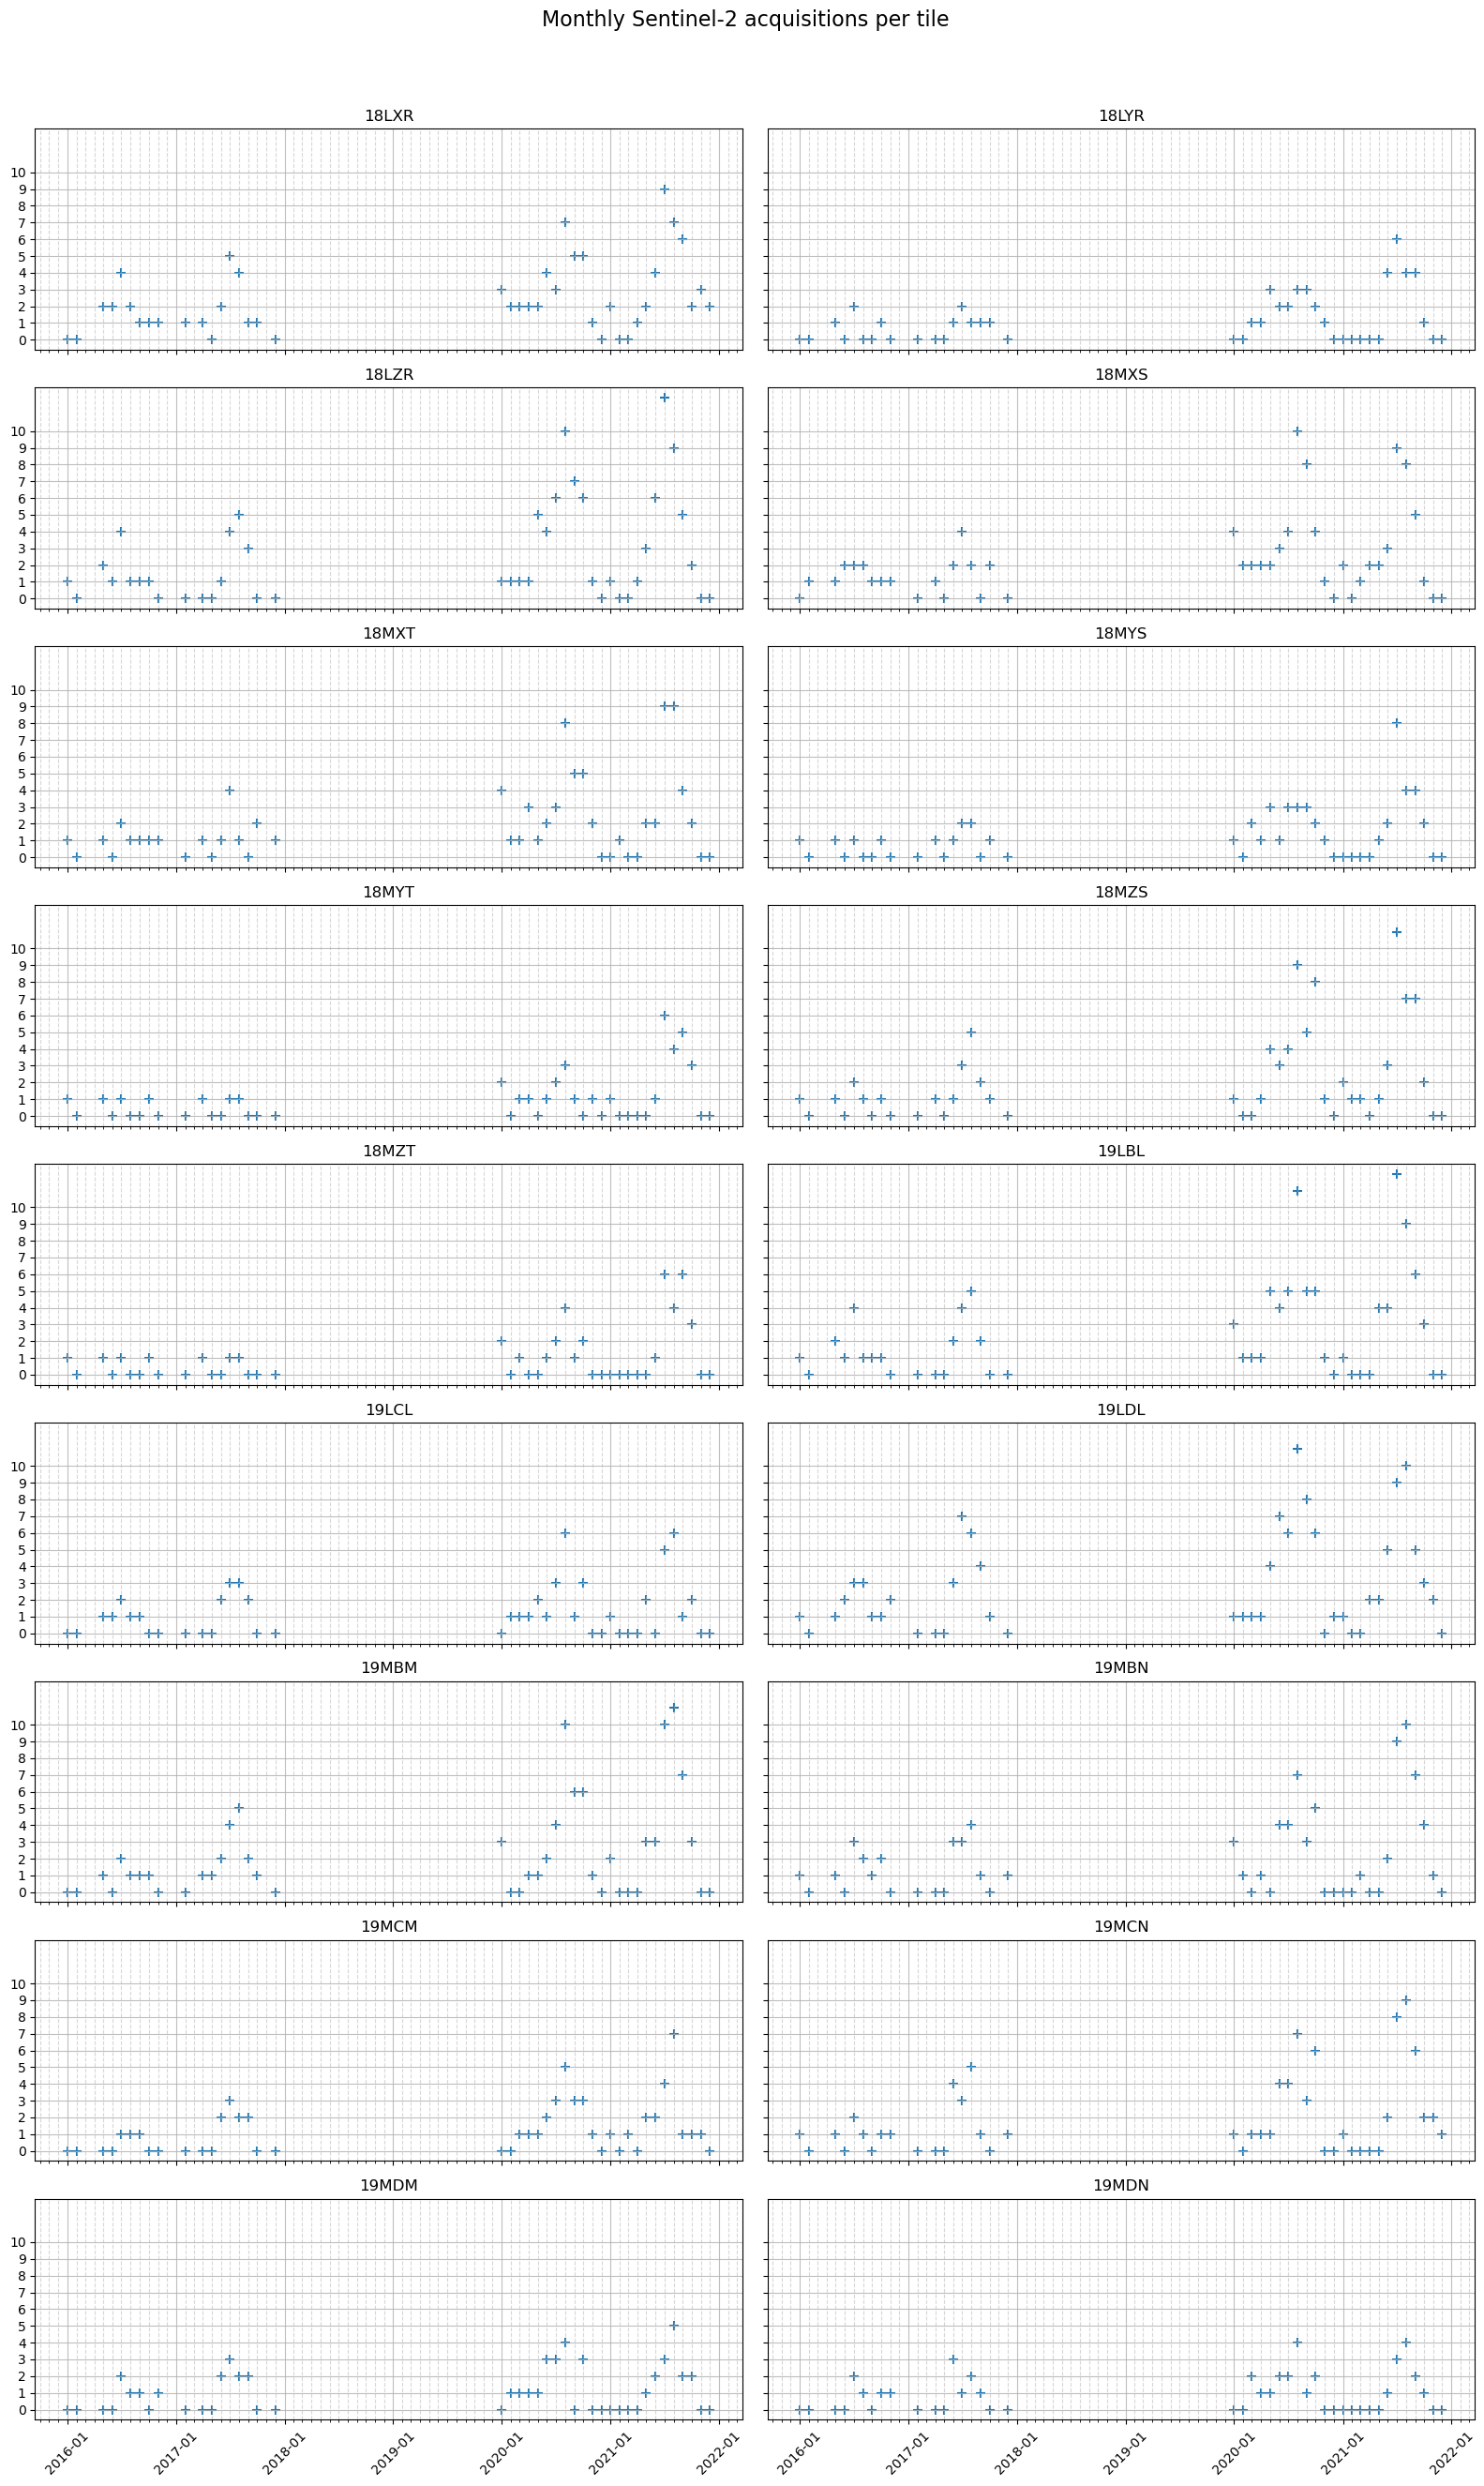

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

# Number of tiles
tiles = counts.columns
n_tiles = len(tiles)

# Determine grid size
n_cols = 2  # number of columns in the subplot grid
n_rows = math.ceil(n_tiles / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 3*n_rows), sharex=True, sharey=True)
axes = axes.flatten()  # flatten in case of 2D array

for i, tile in enumerate(tiles):
    ax = axes[i]
    ax.scatter(counts.index, counts[tile], color='tab:blue', s=50, marker = "+")
    ax.set_title(tile)
    ax.tick_params(axis='x', rotation=45)
    # Format x-axis to show year-month
    ax.xaxis.set_minor_locator(mdates.MonthLocator())  
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  
        
    # Grid on minor ticks (months)
    ax.grid(which="minor", linestyle="--", alpha=0.5)
    ax.grid(which="major", linestyle="-", alpha=0.8)


# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Monthly Sentinel-2 acquisitions per tile", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Number of SEN2 images over each polygon

✅ Number of overlapping images computed for each polygon


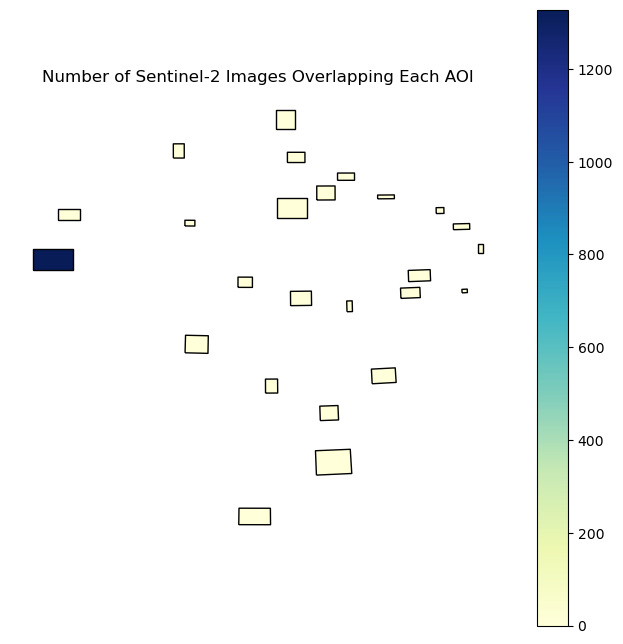

In [26]:
import geopandas as gpd
from shapely.geometry import shape
import pandas as pd

# Convert filtered_items (from stackstac search or STAC API) to GeoDataFrame
geoms = [shape(item.geometry) for item in filtered_items]
gdf_images = gpd.GeoDataFrame(pd.DataFrame(filtered_items), geometry=geoms, crs="EPSG:4326")

# Spatial join to find which images overlap each AOI polygon
join = gpd.sjoin(gdf_images, gdf_wgs84, predicate="intersects", how="inner")

# Count number of images per AOI polygon
image_counts = join.groupby("index_right").size()

# Add results back to the AOI shapefile
gdf["n_images"] = gdf.index.map(image_counts).fillna(0).astype(int)

print("✅ Number of SEN2 overlapping images computed for each polygon")

# Optional: visualize counts
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column="n_images", cmap="YlGnBu", legend=True, edgecolor="black", ax=ax)
ax.set_title("Number of Sentinel-2 Images Overlapping Each AOI", fontsize=12)
ax.axis("off")
plt.show()


### Display SEN2 images

## 4. Access SEN-1

In [37]:
# retrieving the relevant STAC Item
api = pystac_client.Client.open(
    "https://stacapi-cdos.apps.okd.crocc.meso.umontpellier.fr",
    modifier=tld.sign_inplace,
)

today = date.today()
last_year = today.replace(year=today.year - 1).strftime("%Y-%m")
time_range = f"2016-01-01/2021-12-31"
search = api.search(
    collections=["s1-grd-sigma0-ortho"], datetime=time_range, bbox=bbox_polyi
)
sen1items = search.item_collection()
print(f"{len(sen1items)} items found")

37 items found


In [46]:
item = sen1items[0]
assets = [asset.description for asset in item.assets.values()]
descriptions = pd.DataFrame(
    assets,
    columns=["Description"],
    index=pd.Series(item.assets.keys(), name="asset_key"),
)
pd.set_option('display.max_colwidth', 200)
descriptions

Description
asset_key                                                                                                        
LI          Local Incidence image (angle between the surface normal and the satellite): inc_deg = 0.01 * px - 180
MD                                                                                 Metadata : manifest.safe  file
QL                                                                                     grayscaled image quicklook
VH                                                                    VH polarized image: vh_db = 0.001 * px - 40
VV                                                                    VV polarized image: vv_db = 0.001 * px - 40
MDVH                                                                               Metadata : vh annotations file
MDVV                                                                               Metadata : vv annotations file
MDVH-RFI                                                                       Metadata : vh RFI annotations file
MDVV-RFI                                                                       Metadata : vv RFI annotations file
MDVH-CALIB                                                             Metadata : vh calibration annotations file
MDVH-NOISE                                                                   Metadata : vh noise annotations file
MDVV-CALIB                                                             Metadata : vv calibration annotations file
MDVV-NOISE                                                                   Metadata : vv noise annotations file

In [38]:
sen1items[0]

<Item id=S1B_IW_GRDH_1SDV_20161223T103736_20161223T103801_SIG0_ORT_T18LXR>

### Number of SEN1 images over each polygon

✅ Number of overlapping SEN1 images computed for each polygon


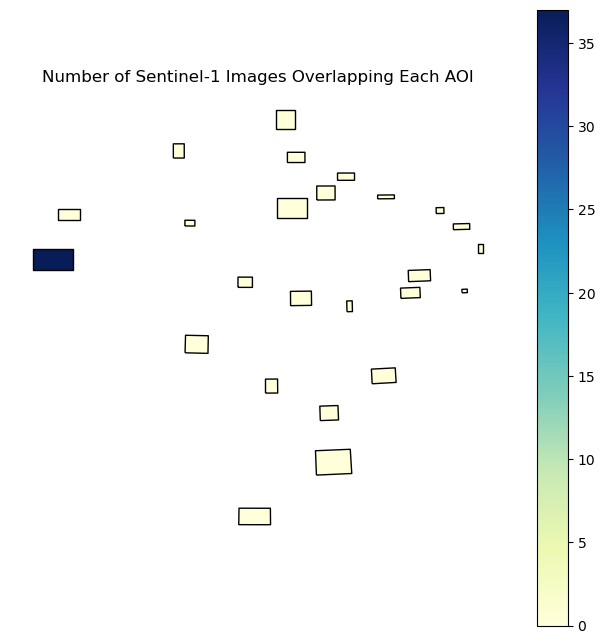

In [39]:
import geopandas as gpd
from shapely.geometry import shape
import pandas as pd

# Convert filtered_items (from stackstac search or STAC API) to GeoDataFrame
geoms = [shape(item.geometry) for item in sen1items]
gdf_images = gpd.GeoDataFrame(pd.DataFrame(sen1items), geometry=geoms, crs="EPSG:4326")

# Spatial join to find which images overlap each AOI polygon
join = gpd.sjoin(gdf_images, gdf_wgs84, predicate="intersects", how="inner")

# Count number of images per AOI polygon
image_counts = join.groupby("index_right").size()

# Add results back to the AOI shapefile
gdf["n_images"] = gdf.index.map(image_counts).fillna(0).astype(int)

print("✅ Number of overlapping SEN1 images computed for each polygon")

# Optional: visualize counts
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column="n_images", cmap="YlGnBu", legend=True, edgecolor="black", ax=ax)
ax.set_title("Number of Sentinel-1 Images Overlapping Each AOI", fontsize=12)
ax.axis("off")
plt.show()


### SEN-1 acquisitions over time

In [47]:
bands = ["QL","VH","VV"]
FILL_VALUE = 2**16 - 1
sen1array = stackstac.stack(
    sen1items,
    assets=bands,
    resolution=10,
    fill_value=FILL_VALUE,
    bounds_latlon=bbox_polyi,
    epsg = 4326,
)
sen1array

<xarray.DataArray 'stackstac-a645f48676f783f242ea154504912e90' (time: 37,
                                                                band: 3, y: 1,
                                                                x: 2)> Size: 2kB
dask.array<fetch_raster_window, shape=(37, 3, 1, 2), dtype=float64, chunksize=(1, 1, 1, 2), chunktype=numpy.ndarray>
Coordinates: (12/41)
  * time                                   (time) datetime64[ns] 296B 2016-02...
    id                                     (time) <U64 9kB 'S1A_IW_GRDH_1SDV_...
  * band                                   (band) <U2 24B 'QL' 'VH' 'VV'
  * x                                      (x) float64 16B -80.0 -70.0
  * y                                      (y) float64 8B 0.0
    sar:pixel_spacing_azimuth              float64 8B 10.0
    ...                                     ...
    sat:orbit_state                        <U10 40B 'descending'
    description                            (band) <U43 516B 'grayscaled image...
    production:implementation_sha          <U40 160B '5d8ebe2d697f69e06b6387d...
    production:definition_sha              <U40 160B 'fb44f25dec27e95f84157fc...
    proj:shape                             (band) object 24B None ... [10980,...
    epsg                                   int32 4B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-80, -10, -60, 0), resolutions...
    crs:         epsg:4326
    transform:   | 10.00, 0.00,-80.00|\n| 0.00,-10.00, 0.00|\n| 0.00, 0.00, 1...
    resolution:  10

C:\Users\pedro\AppData\Local\Temp\ipykernel_11124\459903856.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


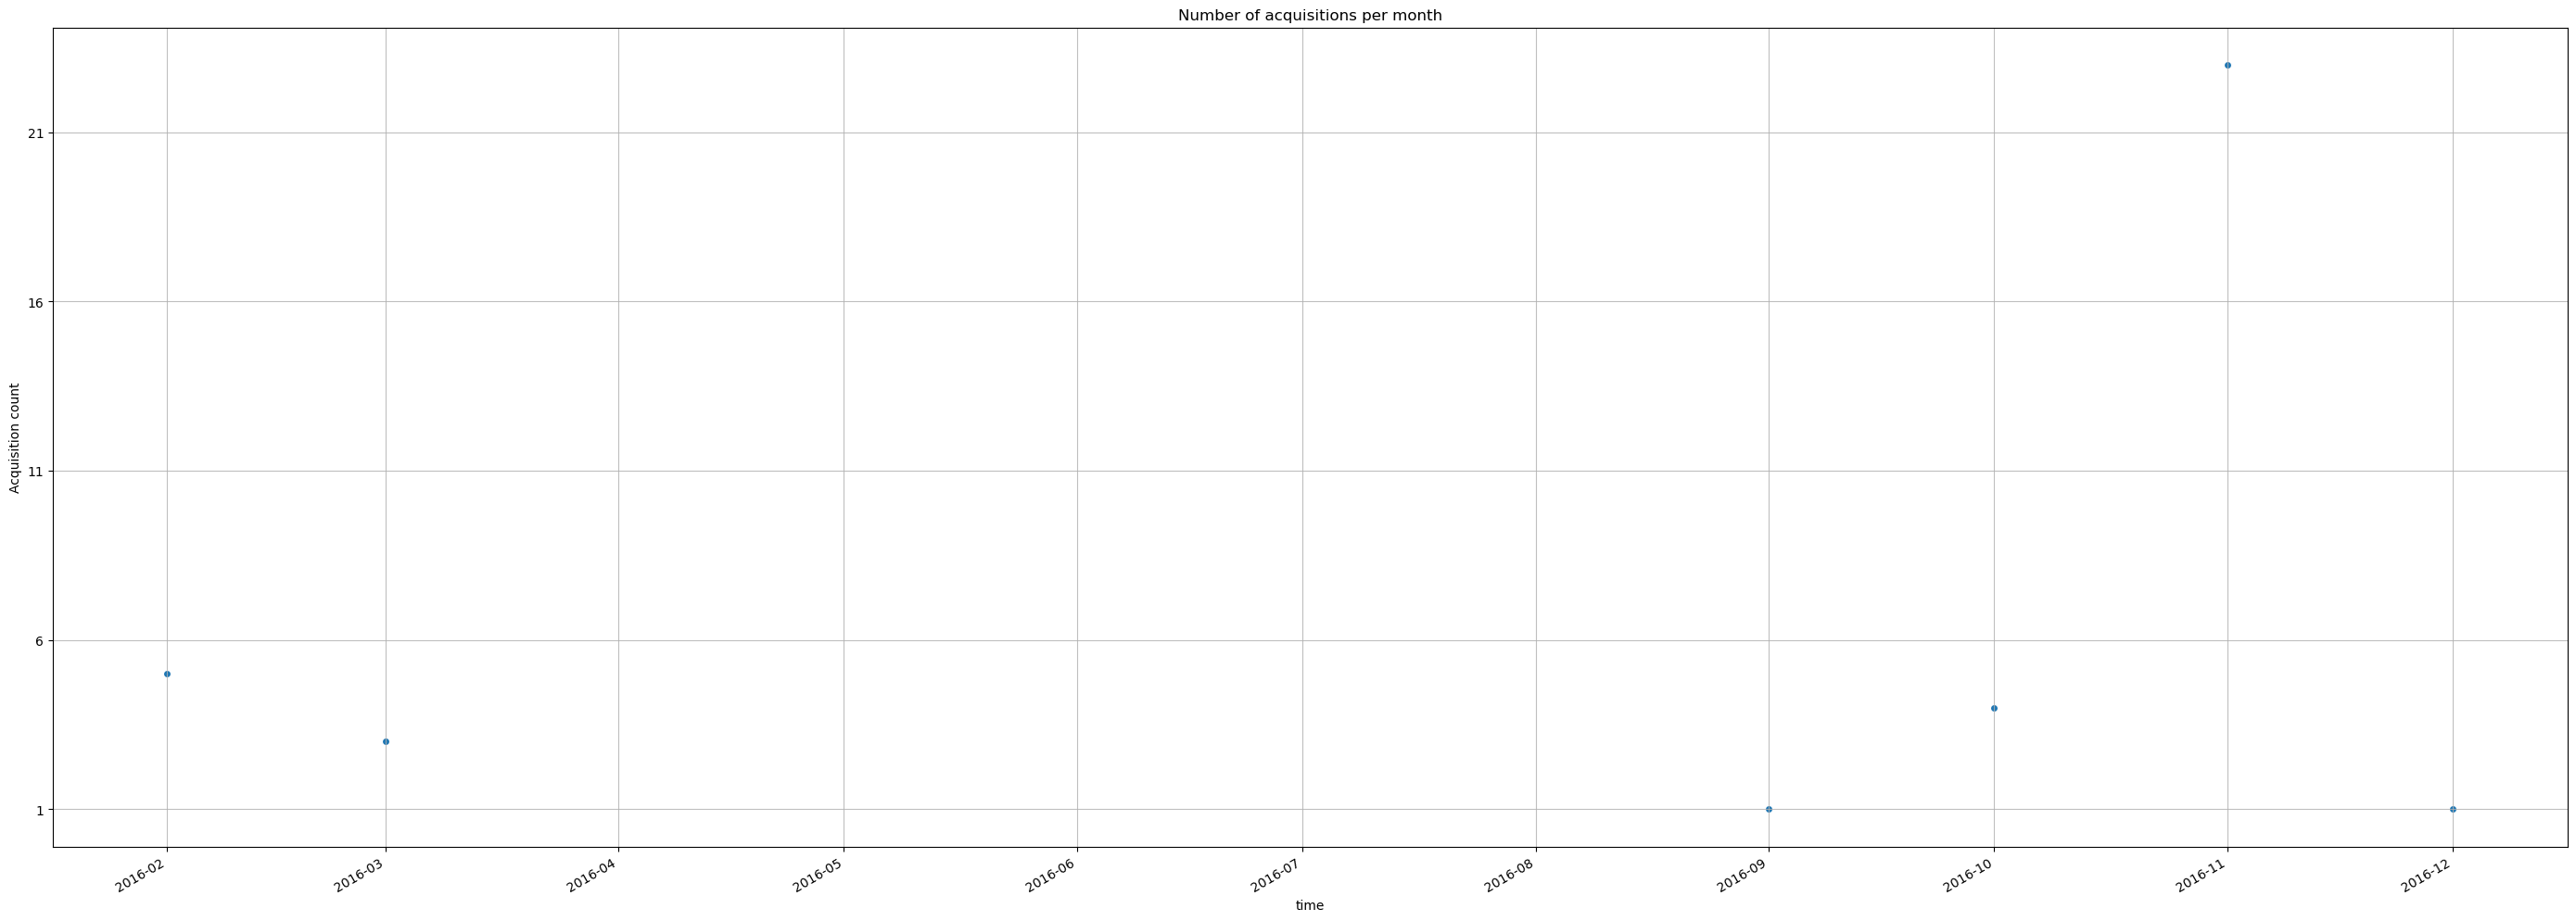

In [48]:
 # counting the number of acquisitons per month
import matplotlib.dates as mdates

# resampling and counting for each month
# using MS (Month Start) as we prefer using the first day
# of the month as a reference point instead of the last
# acquisition date of the month
s1ar = sen1array.time.sortby("time").resample(time="MS").count()


fig, ax = plt.subplots(figsize=(35, 13))
s1ar.plot.scatter(ax=ax, x="time")
ax.set_ylabel("Acquisition count")
ax.set_title("Number of acquisitions per month")

# setting y ticks manually to avoid non-integer values being used
ymin = int(s1ar.min().values)
ymax = int(s1ar.max().values)

ax.set_yticks(range(ymin, ymax + 1,5))

# Format x-axis to show year-month
ax.xaxis.set_minor_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  

fig.autofmt_xdate()  # rotate labels so they don't overlap

# Grid on minor ticks (months)
ax.grid(which="minor", linestyle="--", alpha=0.5)
ax.grid(which="major", linestyle="-", alpha=0.8)

fig.show()